In [2]:
"""
Calculates the Cost and Latency for OS LLM
"""
import pandas as pd
import matplotlib.pyplot as plt
import json

In [3]:
# data = json.load( open("benchmark_test1.json") )
data = json.load( open("benchmark_test2_long.json") )


In [4]:
df = {k : [] for k in data[0].keys()}

In [5]:
for d in data:
    if 'completion_tokens' in d:
        for k,v in d.items():
            df[k].append(v)

In [6]:
df = pd.DataFrame(df)

In [7]:
df

,completion_tokens,prompt_tokens,total_tokens,time,parallel_requests,text,tok_per_sec
0,2048,572,2620,67.986900,1,"\n ""Once upon a time in the mystica...",30.123450
1,2048,572,2620,79.985160,8,"\n ""Once upon a time in the mystica...",25.604750
2,2048,572,2620,79.999814,8,"\n ""Once upon a time in the mystica...",25.600060
3,2048,572,2620,79.995845,8,"\n ""Once upon a time in the mystica...",25.601330
4,2048,572,2620,79.993618,8,"\n ""Once upon a time in the mystica...",25.602042
...,...,...,...,...,...,...,...
368,2048,572,2620,681.101582,128,"\n ""Once upon a time in the mystica...",3.006894
369,2048,572,2620,681.698194,128,"\n ""Once upon a time in the mystica...",3.004262
370,2048,572,2620,682.245793,128,"\n ""Once upon a time in the mystica...",3.001851
371,2048,572,2620,689.674731,128,"\n ""Once upon a time in the mystica...",2.969516


In [8]:
df_tok = df[['parallel_requests']]
df_tok['total_tok_per_sec_nparallel'] = df['tok_per_sec']

df_tok.groupby('parallel_requests').sum()

/tmp/ipykernel_185125/1297122929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tok['total_tok_per_sec_nparallel'] = df['tok_per_sec']


,total_tok_per_sec_nparallel
parallel_requests,
1,30.123450
8,204.817158
16,345.480337
24,447.821175
32,516.208836
64,710.706785
100,861.856424
128,949.117489


In [9]:
# calculate best case and worst case costs

In [10]:
# best case : 
# full machine utilization
# server runs with 128 parallel request

n_parallel = 128
machine_cost_per_hr = 1.2

bar_graph_data = {}
line_graph_data = {}
n_session_data = {}
n_gen_tokens_data = {}


for n_parallel in df['parallel_requests'].unique():
    df_nparallel  = df[df['parallel_requests'] == n_parallel]
    assert df_nparallel.shape[0] == n_parallel
    print( f"n_parallel {n_parallel}")
    print( f"mean {df_nparallel['time'].mean()}   max {df_nparallel['time'].max()}   min {df_nparallel['time'].min()}" )
    # we consider the worst case of the best case i.e. take the max
    # Assume that users are waiting in queue post n_parallel are filled
    time_taken_per_request = df_nparallel['time'].max()
    batch_served_per_hr = (60*60) // time_taken_per_request
    sessions_served_per_hr = batch_served_per_hr * n_parallel

    cost_per_session = machine_cost_per_hr / sessions_served_per_hr
    cost_per_session_rs = cost_per_session * 82
    # print(cost_per_session_rs, "\n")
    bar_graph_data[n_parallel] = cost_per_session_rs
    line_graph_data[n_parallel] = df_nparallel['tok_per_sec'].mean()
    n_session_data[n_parallel] = sessions_served_per_hr

    n_gen_tokens_data[n_parallel] = df_nparallel['completion_tokens'].mean()

n_parallel 1
mean 67.98689985275269   max 67.98689985275269   min 67.98689985275269
n_parallel 8
mean 79.99329859018326   max 80.0016233921051   min 79.98516035079956
n_parallel 16
mean 95.29110273718834   max 113.66506171226501   min 91.74617099761963
n_parallel 24
mean 113.41032223900159   max 149.96386623382568   min 94.77866005897522
n_parallel 32
mean 134.413232088089   max 183.86213970184326   min 99.16227531433105
n_parallel 64
mean 221.2254925556481   max 359.361941576004   min 104.2473213672638
n_parallel 100
mean 316.84123738527296   max 557.4124608039856   min 104.36845588684082
n_parallel 128
mean 390.7525284513831   max 701.929493188858   min 104.3434112071991


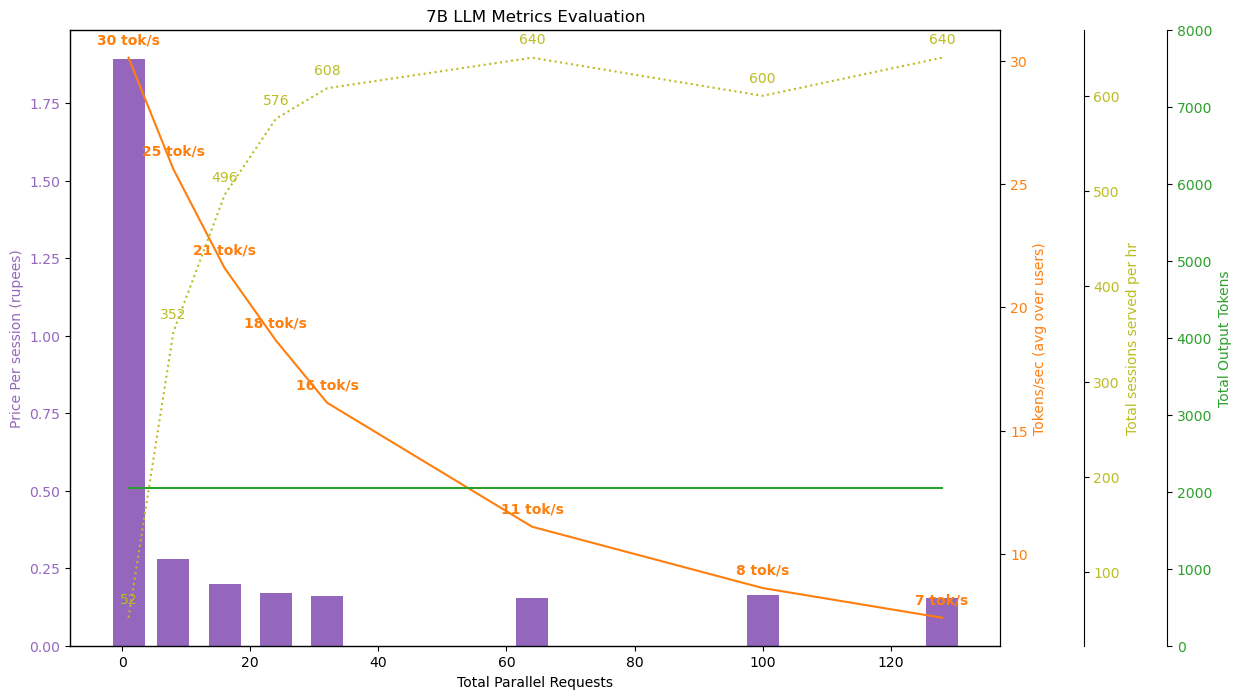

In [12]:

# Create bar graph
fig, ax1 = plt.subplots(figsize=(12, 8))

color = 'tab:purple'
ax1.set_xlabel('Total Parallel Requests')
ax1.set_ylabel('Price Per session (rupees)', color=color)
ax1.bar(bar_graph_data.keys(), bar_graph_data.values(), 5, color=color, align='center')
ax1.tick_params(axis='y', labelcolor=color)

# Create line graph on the right axis
ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('Tokens/sec (avg over users)', color=color)
ax2.plot(line_graph_data.keys(), line_graph_data.values(), color=color)
ax2.tick_params(axis='y', labelcolor=color)
# Add ticks with values on the second line graph
for i, value in enumerate(line_graph_data.values()):
    ax2.annotate(f'{int(value)} tok/s', (list(line_graph_data.keys())[i], value),
                  textcoords="offset points", xytext=(0, 10), ha='center', color=color, fontweight='bold')


# Create second line graph on a new axis
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the new axis to the right
color = 'tab:olive'
ax3.set_ylabel('Total sessions served per hr', color=color)
ax3.plot(n_session_data.keys(), n_session_data.values(), color=color, linestyle='dotted')
ax3.tick_params(axis='y', labelcolor=color)
# Add ticks with values on the second line graph
for i, value in enumerate(n_session_data.values()):
    ax3.annotate(f'{int(value)}', (list(n_session_data.keys())[i], value), textcoords="offset points", xytext=(0, 10), ha='center', color=color)


# Create line graph on the right axis
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))  # Move the new axis to the right
color = 'tab:green'
ax4.set_ylabel('Total Output Tokens', color=color)
ax4.plot(n_gen_tokens_data.keys(), n_gen_tokens_data.values(), color=color)
ax4.tick_params(axis='y', labelcolor=color)
ax4.set_ylim(0, 8000)


# Show the plot
plt.title('7B LLM Metrics Evaluation')
plt.show()